# CNN

### Import libraries

In [ ]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from random import sample

## Load train & test data

In [ ]:
transformer = transforms.Compose([transforms.ToTensor(), 
                                  transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                 ])

batch_size = 4
train_data = torchvision.datasets.CIFAR10(root='./cifar10', train=True,
                                          download=True, transform=transformer)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
                                           shuffle=True)

test_data = torchvision.datasets.CIFAR10(root='./cifar10', train=False,
                                         download=True, transform=transformer)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size,
                                         shuffle=False)


Extracting ./cifar10/cifar-10-python.tar.gz to ./cifar10
Files already downloaded and verified


## Define CNN network

In [ ]:
class BaseCNN(nn.Module):
    def __init__(self):
        super().__init__()
        # Filter Layer 1
        self.conv11 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1, stride=1)
        self.conv12 = nn.Conv2d(in_channels=32, out_channels=72, kernel_size=4, padding=1, stride=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=1)

        # Filter Layer 2
        self.conv21 = nn.Conv2d(in_channels=72, out_channels=120, kernel_size=3, padding=1, stride=1)
        self.conv22 = nn.Conv2d(in_channels=120, out_channels=64, kernel_size=3, padding=1, stride=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Filter Layer 3
        self.conv31 = nn.Conv2d(in_channels=64, out_channels=45, kernel_size=2, padding=1, stride=1)
        self.conv32 = nn.Conv2d(in_channels=45, out_channels=16, kernel_size=3, padding=1, stride=1)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Fully connected layers
        self.fc1 = nn.Linear(16 * 8 * 8, 256)
        self.fc2 = nn.Linear(256, 64)
        self.fc3 = nn.Linear(64, 10)

        self.ReLU = nn.ReLU()

    def forward(self, input):
        # Filter Layer 1
        input = self.conv11(input)
        input = self.ReLU(input)
        input = self.conv12(input)
        input = self.ReLU(input)
        input = self.pool1(input)

        # Filter Layer 2
        input = self.conv21(input)
        input = self.ReLU(input)
        input = self.conv22(input)
        input = self.ReLU(input)
        input = self.pool2(input)

        # Filter Layer 3
        input = self.conv31(input)
        input = self.ReLU(input)
        input = self.conv32(input)
        input = self.ReLU(input)
        input = self.pool3(input)

        input = torch.flatten(input, 1)
        # Fully connected layers
        input = self.fc1(input)
        input = self.ReLU(input)
        input = self.fc2(input)
        input = self.ReLU(input)
        input = self.fc3(input)

        return input

## Train and Test Model

In [ ]:
def train(model, train_loader, test_loader, epochs_num, optimizer, loss_function, train_size, test_size):
  epochs_train_loss = []
  epochs_test_loss = []
  epochs_train_acc = []
  epochs_test_acc = []
  for epoch in range(1, epochs_num+1):
    batches_train_loss = []
    batches_train_predictions = []
    batches_train_targets = []

    for index, data in enumerate(train_loader):
      features, targets = data
      features, targets = features.cuda(), targets.cuda()
      optimizer.zero_grad()
      output = model(features)
      _, prediction = torch.max(output.data, 1)

      loss = loss_function(output, targets)

      loss.backward()
      optimizer.step()

      batches_train_loss.append(loss.item())

      batches_train_predictions.extend(prediction.cpu())
      batches_train_targets.extend(targets.cpu())

      if (index+1) % 2000==0:
          print("Batch number {} is finished!".format(index+1))
    
    batches_test_predictions, batches_test_targets, batches_test_loss = test(model, test_loader, optimizer, loss_function)
    epochs_train_acc.append(accuracy_score(batches_train_targets, batches_train_predictions))
    epochs_train_loss.append(np.sum(batches_train_loss)/train_size)

    epochs_test_acc.append(accuracy_score(batches_test_targets, batches_test_predictions))
    epochs_test_loss.append(np.sum(batches_test_loss)/test_size)

    print('Epoch {} is finished!'.format(epoch))
  return epochs_train_loss, epochs_test_loss, epochs_train_acc, epochs_test_acc

In [ ]:
def test(model, test_loader, optimizer, loss_function):
  batches_test_loss = []
  batches_test_predictions = []
  batches_test_targets = []
  with torch.no_grad():
    for features, target in test_loader:
      features, target = features.cuda(), target.cuda()
      output = model(features)
      _, prediction = torch.max(output.data, 1)
      loss = loss_function(output, target).item()
      batches_test_loss.append(loss)
      batches_test_predictions.extend(prediction.cpu())
      batches_test_targets.extend(target.cpu())
    
  return batches_test_predictions, batches_test_targets, batches_test_loss



## Plot Accuracy and Loss

In [ ]:
def plot_result(epochs_train, epochs_test, epochs_num, title):
  x_axis = range(1, epochs_num+1)
  legends = ['train', 'test']
  x_label = 'Epoch'
  plt.plot(x_axis, epochs_train)
  plt.plot(x_axis, epochs_test)
  plt.title(title)
  plt.xlabel(x_label)
  plt.legend(legends)
  plt.show()

## Run Base Network

In [ ]:
base_net = BaseCNN()
base_net.cuda()

BaseCNN(
  (conv11): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv12): Conv2d(32, 72, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
  (conv21): Conv2d(72, 120, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv22): Conv2d(120, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv31): Conv2d(64, 45, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (conv32): Conv2d(45, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
  (ReLU): ReLU()
)

## Define Loss Func

In [ ]:
criterion = nn.CrossEntropyLoss()

## Define Optimizer & Run model

In [ ]:
base_optimizer = optim.SGD(base_net.parameters(), lr=0.001, momentum=0.9)
epochs_train_loss, epochs_test_loss, epochs_train_acc, epochs_test_acc = train(base_net, train_loader, test_loader, 20, base_optimizer, criterion, len(train_data), len(test_data))

Batch number 2000 is finished!
Batch number 4000 is finished!
Batch number 6000 is finished!
Batch number 8000 is finished!
Batch number 10000 is finished!
Batch number 12000 is finished!
Epoch 1 is finished!
Batch number 2000 is finished!
Batch number 4000 is finished!
Batch number 6000 is finished!
Batch number 8000 is finished!
Batch number 10000 is finished!
Batch number 12000 is finished!
Epoch 2 is finished!
Batch number 2000 is finished!
Batch number 4000 is finished!
Batch number 6000 is finished!
Batch number 8000 is finished!
Batch number 10000 is finished!
Batch number 12000 is finished!
Epoch 3 is finished!
Batch number 2000 is finished!
Batch number 4000 is finished!
Batch number 6000 is finished!
Batch number 8000 is finished!
Batch number 10000 is finished!
Batch number 12000 is finished!
Epoch 4 is finished!
Batch number 2000 is finished!
Batch number 4000 is finished!
Batch number 6000 is finished!
Batch number 8000 is finished!
Batch number 10000 is finished!
Batch nu

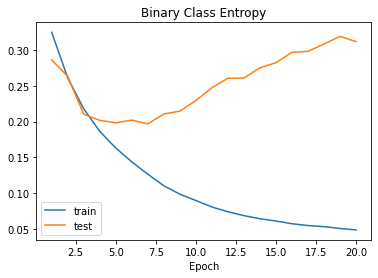

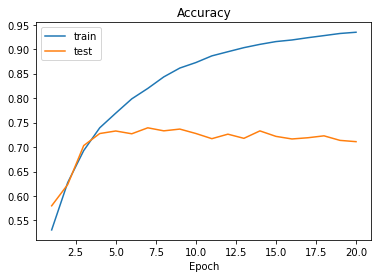

In [ ]:
plot_result(epochs_train_loss, epochs_test_loss, 20, "Cross Entropy")
plot_result(epochs_train_acc, epochs_test_acc, 20, "Accuracy")

## 2.3. Different layer count

### CNN With 0 hidden layer

In [ ]:
class ZeroHiddenLayerCNN(nn.Module):
    def __init__(self):
        super().__init__()
        # Fully connected layers
        self.fc1 = nn.Linear(32 * 32 * 3, 256)
        self.fc2 = nn.Linear(256, 64)
        self.fc3 = nn.Linear(64, 10)

        self.ReLU = nn.ReLU()

    def forward(self, input):

        input = torch.flatten(input, 1)
        # Fully connected layers
        input = self.fc1(input)
        input = self.ReLU(input)
        input = self.fc2(input)
        input = self.ReLU(input)
        input = self.fc3(input)

        return input

Batch number 2000 is finished!
Batch number 4000 is finished!
Batch number 6000 is finished!
Batch number 8000 is finished!
Batch number 10000 is finished!
Batch number 12000 is finished!
Epoch 1 is finished!
Batch number 2000 is finished!
Batch number 4000 is finished!
Batch number 6000 is finished!
Batch number 8000 is finished!
Batch number 10000 is finished!
Batch number 12000 is finished!
Epoch 2 is finished!
Batch number 2000 is finished!
Batch number 4000 is finished!
Batch number 6000 is finished!
Batch number 8000 is finished!
Batch number 10000 is finished!
Batch number 12000 is finished!
Epoch 3 is finished!
Batch number 2000 is finished!
Batch number 4000 is finished!
Batch number 6000 is finished!
Batch number 8000 is finished!
Batch number 10000 is finished!
Batch number 12000 is finished!
Epoch 4 is finished!
Batch number 2000 is finished!
Batch number 4000 is finished!
Batch number 6000 is finished!
Batch number 8000 is finished!
Batch number 10000 is finished!
Batch nu

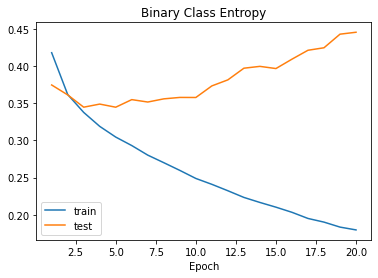

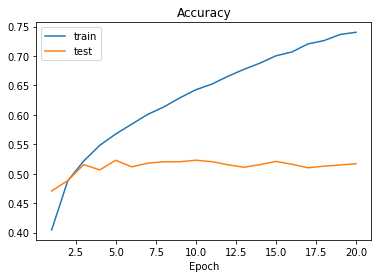

In [ ]:
zero_hidden_net = ZeroHiddenLayerCNN()
zero_hidden_net.cuda()
criterion = nn.CrossEntropyLoss()
zero_optimizer = optim.SGD(zero_hidden_net.parameters(), lr=0.001, momentum=0.9)
epochs_train_loss, epochs_test_loss, epochs_train_acc, epochs_test_acc = train(zero_hidden_net, train_loader, test_loader, 20, zero_optimizer, criterion, len(train_data), len(test_data))
plot_result(epochs_train_loss, epochs_test_loss, 20, "Cross Entropy")
plot_result(epochs_train_acc, epochs_test_acc, 20, "Accuracy")

### CNN With 1 hidden layer

In [ ]:
class OneHiddenLayerCNN(nn.Module):
    def __init__(self):
        super().__init__()
        # Filter Layer 1
        self.conv11 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1, stride=1)
        self.conv12 = nn.Conv2d(in_channels=32, out_channels=72, kernel_size=4, padding=1, stride=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=1)
        
        # Fully connected layers
        self.fc1 = nn.Linear(72 * 30 * 30, 256)
        self.fc2 = nn.Linear(256, 64)
        self.fc3 = nn.Linear(64, 10)

        self.ReLU = nn.ReLU()

    def forward(self, input):
        # Filter Layer 1
        input = self.conv11(input)
        input = self.ReLU(input)
        input = self.conv12(input)
        input = self.ReLU(input)
        input = self.pool1(input)

        input = torch.flatten(input, 1)
        # Fully connected layers
        input = self.fc1(input)
        input = self.ReLU(input)
        input = self.fc2(input)
        input = self.ReLU(input)
        input = self.fc3(input)

        return input

Batch number 2000 is finished!
Batch number 4000 is finished!
Batch number 6000 is finished!
Batch number 8000 is finished!
Batch number 10000 is finished!
Batch number 12000 is finished!
Epoch 1 is finished!
Batch number 2000 is finished!
Batch number 4000 is finished!
Batch number 6000 is finished!
Batch number 8000 is finished!
Batch number 10000 is finished!
Batch number 12000 is finished!
Epoch 2 is finished!
Batch number 2000 is finished!
Batch number 4000 is finished!
Batch number 6000 is finished!
Batch number 8000 is finished!
Batch number 10000 is finished!
Batch number 12000 is finished!
Epoch 3 is finished!
Batch number 2000 is finished!
Batch number 4000 is finished!
Batch number 6000 is finished!
Batch number 8000 is finished!
Batch number 10000 is finished!
Batch number 12000 is finished!
Epoch 4 is finished!
Batch number 2000 is finished!
Batch number 4000 is finished!
Batch number 6000 is finished!
Batch number 8000 is finished!
Batch number 10000 is finished!
Batch nu

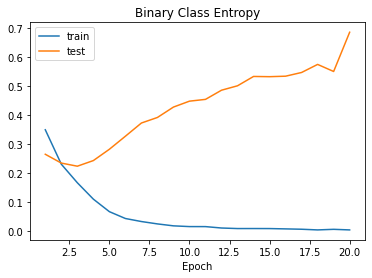

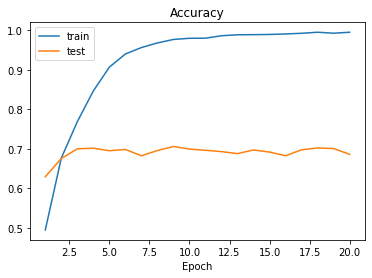

In [ ]:
one_hidden_net = OneHiddenLayerCNN()
one_hidden_net.cuda()
criterion = nn.CrossEntropyLoss()
one_optimizer = optim.SGD(one_hidden_net.parameters(), lr=0.001, momentum=0.9)
epochs_train_loss, epochs_test_loss, epochs_train_acc, epochs_test_acc = train(one_hidden_net, train_loader, test_loader, 20, one_optimizer, criterion, len(train_data), len(test_data))
plot_result(epochs_train_loss, epochs_test_loss, 20, "Cross Entropy")
plot_result(epochs_train_acc, epochs_test_acc, 20, "Accuracy")

### CNN With 2 hidden layer

In [ ]:
class TwoHiddenLayerCNN(nn.Module):
    def __init__(self):
        super().__init__()
        # Filter Layer 1
        self.conv11 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1, stride=1)
        self.conv12 = nn.Conv2d(in_channels=32, out_channels=72, kernel_size=4, padding=1, stride=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=1)

        # Filter Layer 2
        self.conv21 = nn.Conv2d(in_channels=72, out_channels=120, kernel_size=3, padding=1, stride=1)
        self.conv22 = nn.Conv2d(in_channels=120, out_channels=64, kernel_size=3, padding=1, stride=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Fully connected layers
        self.fc1 = nn.Linear(64 * 15 * 15, 256)
        self.fc2 = nn.Linear(256, 64)
        self.fc3 = nn.Linear(64, 10)

        self.ReLU = nn.ReLU()

    def forward(self, input):
        # Filter Layer 1
        input = self.conv11(input)
        input = self.ReLU(input)
        input = self.conv12(input)
        input = self.ReLU(input)
        input = self.pool1(input)

        # Filter Layer 2
        input = self.conv21(input)
        input = self.ReLU(input)
        input = self.conv22(input)
        input = self.ReLU(input)
        input = self.pool2(input)

        input = torch.flatten(input, 1)
        # Fully connected layers
        input = self.fc1(input)
        input = self.ReLU(input)
        input = self.fc2(input)
        input = self.ReLU(input)
        input = self.fc3(input)

        return input

Batch number 2000 is finished!
Batch number 4000 is finished!
Batch number 6000 is finished!
Batch number 8000 is finished!
Batch number 10000 is finished!
Batch number 12000 is finished!
Epoch 1 is finished!
Batch number 2000 is finished!
Batch number 4000 is finished!
Batch number 6000 is finished!
Batch number 8000 is finished!
Batch number 10000 is finished!
Batch number 12000 is finished!
Epoch 2 is finished!
Batch number 2000 is finished!
Batch number 4000 is finished!
Batch number 6000 is finished!
Batch number 8000 is finished!
Batch number 10000 is finished!
Batch number 12000 is finished!
Epoch 3 is finished!
Batch number 2000 is finished!
Batch number 4000 is finished!
Batch number 6000 is finished!
Batch number 8000 is finished!
Batch number 10000 is finished!
Batch number 12000 is finished!
Epoch 4 is finished!
Batch number 2000 is finished!
Batch number 4000 is finished!
Batch number 6000 is finished!
Batch number 8000 is finished!
Batch number 10000 is finished!
Batch nu

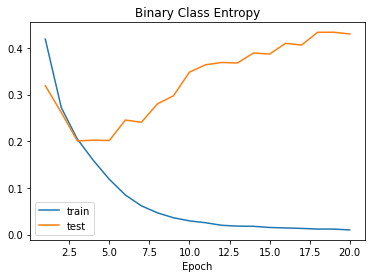

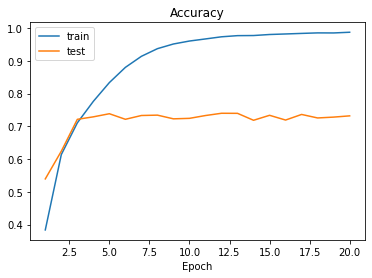

In [ ]:
two_hidden_net = TwoHiddenLayerCNN()
two_hidden_net.cuda()
criterion = nn.CrossEntropyLoss()
two_optimizer = optim.SGD(two_hidden_net.parameters(), lr=0.001, momentum=0.9)
epochs_train_loss, epochs_test_loss, epochs_train_acc, epochs_test_acc = train(two_hidden_net, train_loader, test_loader, 20, two_optimizer, criterion, len(train_data), len(test_data))
plot_result(epochs_train_loss, epochs_test_loss, 20, "Cross Entropy")
plot_result(epochs_train_acc, epochs_test_acc, 20, "Accuracy")

## 2.4. Different activation functions

In [ ]:
class DynamicActivationFuncCNN(nn.Module):
    def __init__(self, activation_func):
        super().__init__()
        # Filter Layer 1
        self.conv11 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1, stride=1)
        self.conv12 = nn.Conv2d(in_channels=32, out_channels=72, kernel_size=4, padding=1, stride=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=1)

        # Filter Layer 2
        self.conv21 = nn.Conv2d(in_channels=72, out_channels=120, kernel_size=3, padding=1, stride=1)
        self.conv22 = nn.Conv2d(in_channels=120, out_channels=64, kernel_size=3, padding=1, stride=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Filter Layer 3
        self.conv31 = nn.Conv2d(in_channels=64, out_channels=45, kernel_size=2, padding=1, stride=1)
        self.conv32 = nn.Conv2d(in_channels=45, out_channels=16, kernel_size=3, padding=1, stride=1)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Fully connected layers
        self.fc1 = nn.Linear(16 * 8 * 8, 256)
        self.fc2 = nn.Linear(256, 64)
        self.fc3 = nn.Linear(64, 10)

        self.activation_func = activation_func

    def forward(self, input):
        # Filter Layer 1
        input = self.conv11(input)
        input = self.activation_func(input)
        input = self.conv12(input)
        input = self.activation_func(input)
        input = self.pool1(input)

        # Filter Layer 2
        input = self.conv21(input)
        input = self.activation_func(input)
        input = self.conv22(input)
        input = self.activation_func(input)
        input = self.pool2(input)

        # Filter Layer 3
        input = self.conv31(input)
        input = self.activation_func(input)
        input = self.conv32(input)
        input = self.activation_func(input)
        input = self.pool3(input)

        input = torch.flatten(input, 1)
        # Fully connected layers
        input = self.fc1(input)
        input = self.activation_func(input)
        input = self.fc2(input)
        input = self.activation_func(input)
        input = self.fc3(input)

        return input

### CNN With RELU

In [ ]:
relu_net = DynamicActivationFuncCNN(nn.ReLU())
relu_net.cuda()
criterion = nn.CrossEntropyLoss()
relu_optimizer = optim.SGD(relu_net.parameters(), lr=0.001, momentum=0.9)
_, _, _, relu_epochs_test_acc = train(relu_net, train_loader, test_loader, 10, relu_optimizer, criterion, len(train_data), len(test_data))

Batch number 2000 is finished!
Batch number 4000 is finished!
Batch number 6000 is finished!
Batch number 8000 is finished!
Batch number 10000 is finished!
Batch number 12000 is finished!
Epoch 1 is finished!
Batch number 2000 is finished!
Batch number 4000 is finished!
Batch number 6000 is finished!
Batch number 8000 is finished!
Batch number 10000 is finished!
Batch number 12000 is finished!
Epoch 2 is finished!
Batch number 2000 is finished!
Batch number 4000 is finished!
Batch number 6000 is finished!
Batch number 8000 is finished!
Batch number 10000 is finished!
Batch number 12000 is finished!
Epoch 3 is finished!
Batch number 2000 is finished!
Batch number 4000 is finished!
Batch number 6000 is finished!
Batch number 8000 is finished!
Batch number 10000 is finished!
Batch number 12000 is finished!
Epoch 4 is finished!
Batch number 2000 is finished!
Batch number 4000 is finished!
Batch number 6000 is finished!
Batch number 8000 is finished!
Batch number 10000 is finished!
Batch nu

### CNN With Sigmoid

In [ ]:
sigmoid_net = DynamicActivationFuncCNN(nn.Sigmoid())
sigmoid_net.cuda()
criterion = nn.CrossEntropyLoss()
sigmoid_optimizer = optim.SGD(sigmoid_net.parameters(), lr=0.001, momentum=0.9)
_, _, _, sigmoid_epochs_test_acc = train(sigmoid_net, train_loader, test_loader, 10, sigmoid_optimizer, criterion, len(train_data), len(test_data))

Batch number 2000 is finished!
Batch number 4000 is finished!
Batch number 6000 is finished!
Batch number 8000 is finished!
Batch number 10000 is finished!
Batch number 12000 is finished!
Epoch 1 is finished!
Batch number 2000 is finished!
Batch number 4000 is finished!
Batch number 6000 is finished!
Batch number 8000 is finished!
Batch number 10000 is finished!
Batch number 12000 is finished!
Epoch 2 is finished!
Batch number 2000 is finished!
Batch number 4000 is finished!
Batch number 6000 is finished!
Batch number 8000 is finished!
Batch number 10000 is finished!
Batch number 12000 is finished!
Epoch 3 is finished!
Batch number 2000 is finished!
Batch number 4000 is finished!
Batch number 6000 is finished!
Batch number 8000 is finished!
Batch number 10000 is finished!
Batch number 12000 is finished!
Epoch 4 is finished!
Batch number 2000 is finished!
Batch number 4000 is finished!
Batch number 6000 is finished!
Batch number 8000 is finished!
Batch number 10000 is finished!
Batch nu

### CNN With Tanh

In [ ]:
tanh_net = DynamicActivationFuncCNN(nn.Tanh())
tanh_net.cuda()
criterion = nn.CrossEntropyLoss()
tanh_optimizer = optim.SGD(tanh_net.parameters(), lr=0.001, momentum=0.9)
_, _, _, tanh_epochs_test_acc = train(tanh_net, train_loader, test_loader, 10, tanh_optimizer, criterion, len(train_data), len(test_data))

Batch number 2000 is finished!
Batch number 4000 is finished!
Batch number 6000 is finished!
Batch number 8000 is finished!
Batch number 10000 is finished!
Batch number 12000 is finished!
Epoch 1 is finished!
Batch number 2000 is finished!
Batch number 4000 is finished!
Batch number 6000 is finished!
Batch number 8000 is finished!
Batch number 10000 is finished!
Batch number 12000 is finished!
Epoch 2 is finished!
Batch number 2000 is finished!
Batch number 4000 is finished!
Batch number 6000 is finished!
Batch number 8000 is finished!
Batch number 10000 is finished!
Batch number 12000 is finished!
Epoch 3 is finished!
Batch number 2000 is finished!
Batch number 4000 is finished!
Batch number 6000 is finished!
Batch number 8000 is finished!
Batch number 10000 is finished!
Batch number 12000 is finished!
Epoch 4 is finished!
Batch number 2000 is finished!
Batch number 4000 is finished!
Batch number 6000 is finished!
Batch number 8000 is finished!
Batch number 10000 is finished!
Batch nu

### Plot different methods results

In [ ]:
def plot_different_methods_results(plot_values, plot_legends, epochs_num, title):
  x_axis = range(1, epochs_num+1)
  x_label = 'Epoch'
  for values in plot_values:
    plt.plot(x_axis, values)
  plt.title(title)
  plt.xlabel(x_label)
  plt.legend(plot_legends)
  plt.show()

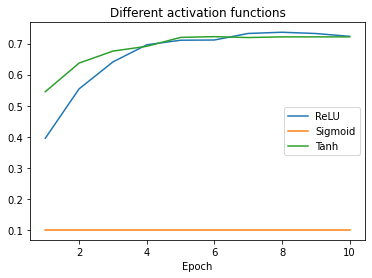

In [ ]:
different_methods_acc = [relu_epochs_test_acc, sigmoid_epochs_test_acc, tanh_epochs_test_acc]
plot_legends = ['ReLU', 'Sigmoid', 'Tanh']
plot_different_methods_results(different_methods_acc, plot_legends, 10, 'Different activation functions')

## 2.5. Different Optimizers

### Adam

In [ ]:
adam_net = BaseCNN()
adam_net.cuda()
criterion = nn.CrossEntropyLoss()
adam_optimizer = optim.Adam(adam_net.parameters(), lr=0.001)
_, _, _, adam_epochs_test_acc = train(adam_net, train_loader, test_loader, 10, adam_optimizer, criterion, len(train_data), len(test_data))

Batch number 2000 is finished!
Batch number 4000 is finished!
Batch number 6000 is finished!
Batch number 8000 is finished!
Batch number 10000 is finished!
Batch number 12000 is finished!
Epoch 1 is finished!
Batch number 2000 is finished!
Batch number 4000 is finished!
Batch number 6000 is finished!
Batch number 8000 is finished!
Batch number 10000 is finished!
Batch number 12000 is finished!
Epoch 2 is finished!
Batch number 2000 is finished!
Batch number 4000 is finished!
Batch number 6000 is finished!
Batch number 8000 is finished!
Batch number 10000 is finished!
Batch number 12000 is finished!
Epoch 3 is finished!
Batch number 2000 is finished!
Batch number 4000 is finished!
Batch number 6000 is finished!
Batch number 8000 is finished!
Batch number 10000 is finished!
Batch number 12000 is finished!
Epoch 4 is finished!
Batch number 2000 is finished!
Batch number 4000 is finished!
Batch number 6000 is finished!
Batch number 8000 is finished!
Batch number 10000 is finished!
Batch nu

### Gradient Descent
It's has been done in previous part ReLU funtion.

### Plot different optimizers results

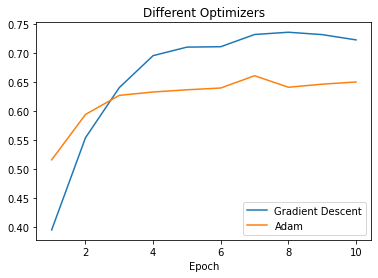

In [ ]:
different_methods_acc = [relu_epochs_test_acc, adam_epochs_test_acc]
plot_legends = ['Gradient Descent', 'Adam']
plot_different_methods_results(different_methods_acc, plot_legends, 10, 'Different Optimizers')

## 2.6. Reduce data size

Epoch 1 is finished!
Epoch 2 is finished!
Epoch 3 is finished!
Epoch 4 is finished!
Epoch 5 is finished!
Epoch 6 is finished!
Epoch 7 is finished!
Epoch 8 is finished!
Epoch 9 is finished!
Epoch 10 is finished!
Epoch 11 is finished!
Epoch 12 is finished!
Epoch 13 is finished!
Epoch 14 is finished!
Epoch 15 is finished!
Epoch 16 is finished!
Epoch 17 is finished!
Epoch 18 is finished!
Epoch 19 is finished!
Epoch 20 is finished!


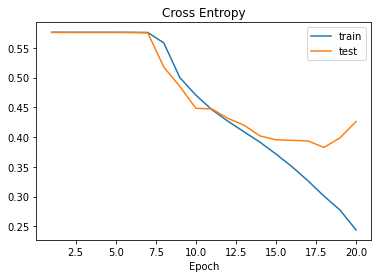

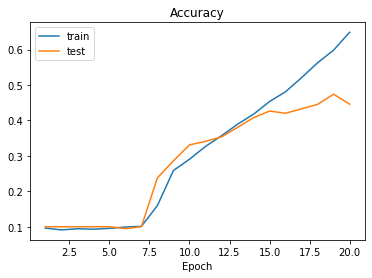

In [ ]:
def downsample_each_class(data_tensor, class_count):
  data = data_tensor.data
  targets = data_tensor.targets
  class_indices = {}
  for index, id in enumerate(targets):
    if id not in class_indices:
      class_indices[id] = list()
    class_indices[id].append(index)
  selected_indices = []
  for class_id, class_index in class_indices.items():
    class_selected_indices = sample(class_index, class_count)
    selected_indices.extend(class_selected_indices)
  reduced_data = torch.utils.data.Subset(train_data, selected_indices)
  return reduced_data
  
reduced_train_data = downsample_each_class(train_data, 600)
reduced_train_loader = torch.utils.data.DataLoader(reduced_train_data, batch_size=batch_size, 
                                                   shuffle=True)
reduced_base_net = BaseCNN()
reduced_base_net.cuda()
criterion = nn.CrossEntropyLoss()
base_optimizer = optim.SGD(reduced_base_net.parameters(), lr=0.001, momentum=0.9)
epochs_train_loss, epochs_test_loss, epochs_train_acc, epochs_test_acc = train(reduced_base_net, reduced_train_loader, test_loader, 20, base_optimizer, 
                                                                               criterion, len(reduced_train_data), len(test_data))
plot_result(epochs_train_loss, epochs_test_loss, 20, "Cross Entropy")
plot_result(epochs_train_acc, epochs_test_acc, 20, "Accuracy")

## 2.7. Replace 2 convolution in each layer to 1 with bigger kernel size

In [ ]:
class BiggerKernelCNN(nn.Module):
    def __init__(self):
        super().__init__()
        # Filter Layer 1
        self.conv11 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5, padding=1, stride=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Filter Layer 2
        self.conv21 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, padding=1, stride=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Filter Layer 3
        self.conv31 = nn.Conv2d(in_channels=64, out_channels=16, kernel_size=5, padding=1, stride=1)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Fully connected layers
        self.fc1 = nn.Linear(16 * 2 * 2, 256)
        self.fc2 = nn.Linear(256, 64)
        self.fc3 = nn.Linear(64, 10)

        self.ReLU = nn.ReLU()

    def forward(self, input):
        # Filter Layer 1
        input = self.conv11(input)
        input = self.ReLU(input)
        input = self.pool1(input)

        # Filter Layer 2
        input = self.conv21(input)
        input = self.ReLU(input)
        input = self.pool2(input)

        # Filter Layer 3
        input = self.conv31(input)
        input = self.ReLU(input)
        input = self.pool3(input)

        input = torch.flatten(input, 1)
        # Fully connected layers
        input = self.fc1(input)
        input = self.ReLU(input)
        input = self.fc2(input)
        input = self.ReLU(input)
        input = self.fc3(input)

        return input

Batch number 2000 is finished!
Batch number 4000 is finished!
Batch number 6000 is finished!
Batch number 8000 is finished!
Batch number 10000 is finished!
Batch number 12000 is finished!
Epoch 1 is finished!
Batch number 2000 is finished!
Batch number 4000 is finished!
Batch number 6000 is finished!
Batch number 8000 is finished!
Batch number 10000 is finished!
Batch number 12000 is finished!
Epoch 2 is finished!
Batch number 2000 is finished!
Batch number 4000 is finished!
Batch number 6000 is finished!
Batch number 8000 is finished!
Batch number 10000 is finished!
Batch number 12000 is finished!
Epoch 3 is finished!
Batch number 2000 is finished!
Batch number 4000 is finished!
Batch number 6000 is finished!
Batch number 8000 is finished!
Batch number 10000 is finished!
Batch number 12000 is finished!
Epoch 4 is finished!
Batch number 2000 is finished!
Batch number 4000 is finished!
Batch number 6000 is finished!
Batch number 8000 is finished!
Batch number 10000 is finished!
Batch nu

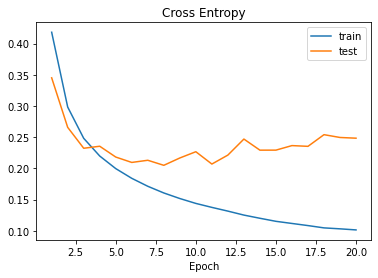

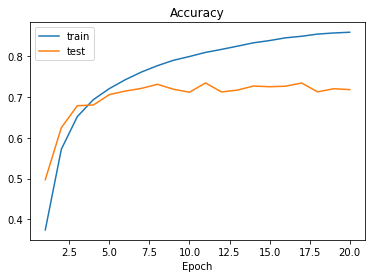

In [ ]:
big_net = BiggerKernelCNN()
big_net.cuda()
criterion = nn.CrossEntropyLoss()
big_optimizer = optim.SGD(big_net.parameters(), lr=0.001, momentum=0.9)
epochs_train_loss, epochs_test_loss, epochs_train_acc, epochs_test_acc = train(big_net, train_loader, test_loader, 20, big_optimizer, criterion, len(train_data), len(test_data))
plot_result(epochs_train_loss, epochs_test_loss, 20, "Cross Entropy")
plot_result(epochs_train_acc, epochs_test_acc, 20, "Accuracy")

## 2.8. Add dropout after each activation function

### 10 Percent dropout

In [ ]:
class DropoutTenCNN(nn.Module):
    def __init__(self):
        super().__init__()
        # Filter Layer 1
        self.conv11 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1, stride=1)
        self.conv12 = nn.Conv2d(in_channels=32, out_channels=72, kernel_size=4, padding=1, stride=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=1)

        # Filter Layer 2
        self.conv21 = nn.Conv2d(in_channels=72, out_channels=120, kernel_size=3, padding=1, stride=1)
        self.conv22 = nn.Conv2d(in_channels=120, out_channels=64, kernel_size=3, padding=1, stride=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Filter Layer 3
        self.conv31 = nn.Conv2d(in_channels=64, out_channels=45, kernel_size=2, padding=1, stride=1)
        self.conv32 = nn.Conv2d(in_channels=45, out_channels=16, kernel_size=3, padding=1, stride=1)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Fully connected layers
        self.fc1 = nn.Linear(16 * 8 * 8, 256)
        self.fc2 = nn.Linear(256, 64)
        self.fc3 = nn.Linear(64, 10)

        self.ReLU = nn.ReLU()
        self.dropout = nn.Dropout(p=0.1)

    def forward(self, input):
        # Filter Layer 1
        input = self.conv11(input)
        input = self.ReLU(input)
        input = self.dropout(input)
        input = self.conv12(input)
        input = self.ReLU(input)
        input = self.dropout(input)
        input = self.pool1(input)

        # Filter Layer 2
        input = self.conv21(input)
        input = self.ReLU(input)
        input = self.dropout(input)
        input = self.conv22(input)
        input = self.ReLU(input)
        input = self.dropout(input)
        input = self.pool2(input)

        # Filter Layer 3
        input = self.conv31(input)
        input = self.ReLU(input)
        input = self.dropout(input)
        input = self.conv32(input)
        input = self.ReLU(input)
        input = self.dropout(input)
        input = self.pool3(input)

        input = torch.flatten(input, 1)
        # Fully connected layers
        input = self.fc1(input)
        input = self.ReLU(input)
        input = self.dropout(input)
        input = self.fc2(input)
        input = self.ReLU(input)
        input = self.dropout(input)
        input = self.fc3(input)

        return input

Batch number 2000 is finished!
Batch number 4000 is finished!
Batch number 6000 is finished!
Batch number 8000 is finished!
Batch number 10000 is finished!
Batch number 12000 is finished!
Epoch 1 is finished!
Batch number 2000 is finished!
Batch number 4000 is finished!
Batch number 6000 is finished!
Batch number 8000 is finished!
Batch number 10000 is finished!
Batch number 12000 is finished!
Epoch 2 is finished!
Batch number 2000 is finished!
Batch number 4000 is finished!
Batch number 6000 is finished!
Batch number 8000 is finished!
Batch number 10000 is finished!
Batch number 12000 is finished!
Epoch 3 is finished!
Batch number 2000 is finished!
Batch number 4000 is finished!
Batch number 6000 is finished!
Batch number 8000 is finished!
Batch number 10000 is finished!
Batch number 12000 is finished!
Epoch 4 is finished!
Batch number 2000 is finished!
Batch number 4000 is finished!
Batch number 6000 is finished!
Batch number 8000 is finished!
Batch number 10000 is finished!
Batch nu

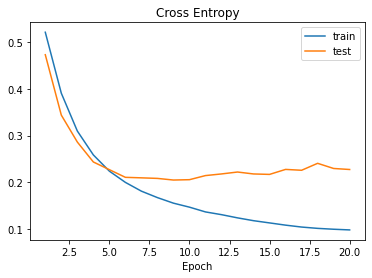

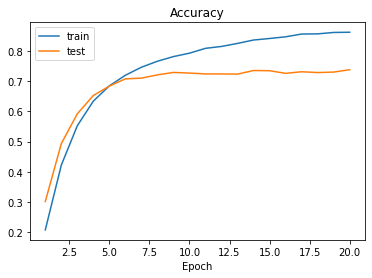

In [ ]:
ten_dropout_net = DropoutTenCNN()
ten_dropout_net.cuda()
criterion = nn.CrossEntropyLoss()
ten_drop_optimizer = optim.SGD(ten_dropout_net.parameters(), lr=0.001, momentum=0.9)
epochs_train_loss, epochs_test_loss, epochs_train_acc, epochs_test_acc = train(ten_dropout_net, train_loader, test_loader, 20, ten_drop_optimizer, criterion, len(train_data), len(test_data))
plot_result(epochs_train_loss, epochs_test_loss, 20, "Cross Entropy")
plot_result(epochs_train_acc, epochs_test_acc, 20, "Accuracy")

### 20 Percent dropout

In [ ]:
class DropoutTwentyCNN(nn.Module):
    def __init__(self):
        super().__init__()
        # Filter Layer 1
        self.conv11 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1, stride=1)
        self.conv12 = nn.Conv2d(in_channels=32, out_channels=72, kernel_size=4, padding=1, stride=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=1)

        # Filter Layer 2
        self.conv21 = nn.Conv2d(in_channels=72, out_channels=120, kernel_size=3, padding=1, stride=1)
        self.conv22 = nn.Conv2d(in_channels=120, out_channels=64, kernel_size=3, padding=1, stride=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Filter Layer 3
        self.conv31 = nn.Conv2d(in_channels=64, out_channels=45, kernel_size=2, padding=1, stride=1)
        self.conv32 = nn.Conv2d(in_channels=45, out_channels=16, kernel_size=3, padding=1, stride=1)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Fully connected layers
        self.fc1 = nn.Linear(16 * 8 * 8, 256)
        self.fc2 = nn.Linear(256, 64)
        self.fc3 = nn.Linear(64, 10)

        self.ReLU = nn.ReLU()
        self.dropout = nn.Dropout(p=0.2)

    def forward(self, input):
        # Filter Layer 1
        input = self.conv11(input)
        input = self.ReLU(input)
        input = self.dropout(input)
        input = self.conv12(input)
        input = self.ReLU(input)
        input = self.dropout(input)
        input = self.pool1(input)

        # Filter Layer 2
        input = self.conv21(input)
        input = self.ReLU(input)
        input = self.dropout(input)
        input = self.conv22(input)
        input = self.ReLU(input)
        input = self.dropout(input)
        input = self.pool2(input)

        # Filter Layer 3
        input = self.conv31(input)
        input = self.ReLU(input)
        input = self.dropout(input)
        input = self.conv32(input)
        input = self.ReLU(input)
        input = self.dropout(input)
        input = self.pool3(input)

        input = torch.flatten(input, 1)
        # Fully connected layers
        input = self.fc1(input)
        input = self.ReLU(input)
        input = self.dropout(input)
        input = self.fc2(input)
        input = self.ReLU(input)
        input = self.dropout(input)
        input = self.fc3(input)

        return input

Batch number 2000 is finished!
Batch number 4000 is finished!
Batch number 6000 is finished!
Batch number 8000 is finished!
Batch number 10000 is finished!
Batch number 12000 is finished!
Epoch 1 is finished!
Batch number 2000 is finished!
Batch number 4000 is finished!
Batch number 6000 is finished!
Batch number 8000 is finished!
Batch number 10000 is finished!
Batch number 12000 is finished!
Epoch 2 is finished!
Batch number 2000 is finished!
Batch number 4000 is finished!
Batch number 6000 is finished!
Batch number 8000 is finished!
Batch number 10000 is finished!
Batch number 12000 is finished!
Epoch 3 is finished!
Batch number 2000 is finished!
Batch number 4000 is finished!
Batch number 6000 is finished!
Batch number 8000 is finished!
Batch number 10000 is finished!
Batch number 12000 is finished!
Epoch 4 is finished!
Batch number 2000 is finished!
Batch number 4000 is finished!
Batch number 6000 is finished!
Batch number 8000 is finished!
Batch number 10000 is finished!
Batch nu

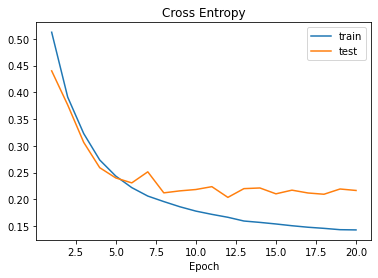

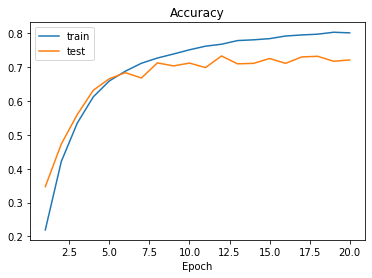

In [ ]:
twenty_dropout_net = DropoutTwentyCNN()
twenty_dropout_net.cuda()
criterion = nn.CrossEntropyLoss()
twenty_drop_optimizer = optim.SGD(twenty_dropout_net.parameters(), lr=0.001, momentum=0.9)
epochs_train_loss, epochs_test_loss, epochs_train_acc, epochs_test_acc = train(twenty_dropout_net, train_loader, test_loader, 20, twenty_drop_optimizer, criterion, len(train_data), len(test_data))
plot_result(epochs_train_loss, epochs_test_loss, 20, "Cross Entropy")
plot_result(epochs_train_acc, epochs_test_acc, 20, "Accuracy")